In [1]:
from collections import deque, namedtuple
import os
from snnUtils import *
from IPython.display import clear_output

from tqdm import tqdm
import pandas as pd
import random, imageio, time, copy
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

import torch.nn as nn
import torch
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

Here we use gymnasium's LuanrLander-v2 environment. According to the documentation, we have four actions in the action space, 0 (Do nnothing), 1 (Fire left orientation engine), 2 (Fire main engine)  , 3 (Fire right orientation engine)

Also the observation space is a ndarray with shape (8,), It is as follows:
- 1, 2: It's  (x,y) coordinates. The landing pad is always at coordinates (0,0).
- 3, 4: It's linear velocities  (xDot,yDot).
- 5: It's angle  Theta.
- 6: It's angular velocity thetaDot
- 7, 8: Two booleans l and r that represent whether each leg is in contact with the ground or not.

Rewards: 
- is increased/decreased the closer/further the lander is to the landing pad.
- is increased/decreased the slower/faster the lander is moving.
- is decreased the more the lander is tilted (angle not horizontal).
- is increased by 10 points for each leg that is in contact with the ground.
- is decreased by 0.03 points each frame a side engine is firing.
- is decreased by 0.3 points each frame the main engine is firing.

The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively. An episode is considered a solution if it scores at least 200 points.

Episode end: The episode finishes if:
- The lander crashes (the lander body gets in contact with the moon);
- The lander gets outside of the viewport (x coordinate is greater than 1);
- The lander is not awake. From the Box2D docs, a body which is not awake is a body which doesn’t move and doesn’t collide with any other body

In [2]:
# Define the super parameters
projectName = "snnRL"

# Save/Get weights from presistent storage. Pass empty string for not saving. 
# Pass derive for using google derive (If code is running in colab). If local, 
# pass the location of your desire
savePath = "./Data"
backUpNetworks = False 
saveLen = 30 # Number of latest checkpoints to save

# Handle save path
if savePath != None:
    if savePath == "derive":
        # Mount gdrive if we want to interact with cloab
        from google.colab import drive
        drive.mount('/content/gdrive')
        savePath = "gdrive/MyDrive/Colab Notebooks/Data/"
    backUpNetworks = True

# Making the environment
env = gym.make("LunarLander-v3") # Use render_mode = "human" to render each episode
state, info = env.reset() # Get a sample state of the environment
stateSize = env.observation_space.shape # Number of variables to define current step
nActions = env.action_space.n # Number of actions
nObs = len(state) # Number of features


# Set pytorch parameters: The device (CPU or GPU) and data types
__device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
__dtype = torch.float

In [3]:
class ReplayMemory(object):
    """
    Implement's the replay memory algorithm.
    """
    def __init__(self, size, dtype, device) -> None:
        """
        Initialize the class with a double ended queue which will contain named tuples.

        Args:
            size (int): The maximum size of the memory buffer.
            dtype (torch.dtype): The data type of the elements in the memory buffer.
            device (torch.device): The device to store the data (CPU or GPU)
        """
        self.exp = deque([], maxlen=size)
        self.len = len(self.exp)
        self.dtype = dtype
        self.device = device

    def addNew(self, exp:namedtuple) -> None:
        """
        Adding a new iteration to the memory. Note that the most recent values of
        the training will be located at the position 0 and if the list reaches maxlen
        the oldest data will be dropped.

        Args:
            exp: namedtuple: The experience should be a named tuple with keys named
                like this: ["state", "action", "reward", "nextState", "done"]
        """
        self.exp.appendleft(exp)
        self.len = len(self.exp)

    def sample(self, miniBatchSize:int, framework = "pytorch") -> tuple:
        """
        Get a random number of experiences from the entire experience memory.
        The memory buffer is a double ended queue (AKA deque) of named tuples. To make
        this list usable for tensor flow neural networks, this each named tuple inside
        the deque has to be unpacked. we use a iterative method to unpack. It may be
        inefficient and maybe using pandas can improve this process. one caveat of using
        pandas tables instead of deque is expensiveness of appending/deleting rows
        (experiences) from the table.

        Args:
            miniBatchSize: int: The size of returned the sample

        Returns:
            A tuple containing state, action, reward, nextState and done
        """
        if framework == "pytorch":
            miniBatch = random.sample(self.exp, miniBatchSize)
            state = torch.from_numpy(np.array([e.state for e in miniBatch if e != None])).to(self.device, dtype = self.dtype)
            action = torch.from_numpy(np.array([e.action for e in miniBatch if e != None])).to(self.device, dtype = torch.int)
            reward = torch.from_numpy(np.array([e.reward for e in miniBatch if e != None])).to(self.device, dtype = self.dtype)
            nextState = torch.from_numpy(np.array([e.nextState for e in miniBatch if e != None])).to(self.device, dtype = self.dtype)
            done = torch.from_numpy(np.array([e.done for e in miniBatch if e != None]).astype(np.uint8)).to(self.device, dtype = torch.int)
        elif framework == "tensorflow":
            miniBatch = random.sample(self.exp, miniBatchSize)
            state = tf.convert_to_tensor(np.array([e.state for e in miniBatch if e != None]), dtype=tf.float32)
            action = tf.convert_to_tensor(np.array([e.action for e in miniBatch if e != None]), dtype=tf.float32)
            reward = tf.convert_to_tensor(np.array([e.reward for e in miniBatch if e != None]), dtype=tf.float32)
            nextState = tf.convert_to_tensor(np.array([e.nextState for e in miniBatch if e != None]), dtype=tf.float32)
            done = tf.convert_to_tensor(np.array([e.done for e in miniBatch if e != None]).astype(np.uint8), dtype=tf.float32)
        return tuple((state, action, reward, nextState, done))

def decayEbsilon(currE: float, rate:float, minE:float) -> float:
    """
    Decreases ebsilon each time called. It multiplies current ebsilon to decrease rate.
    The decreasing is continued until reaching minE.
    """
    return(max(currE*rate, minE))

def computeLoss(experiences:tuple, gamma:float, qNetwork, target_qNetwork):
    """
    Computes the loss between y targets and Q values. For target network, the Q values are
    calculated using Bellman equation. If the reward of current step is R_i, then y = R_i
    if the episode is terminated, if not, y = R_i + gamma * Q_hat(i+1) where gamma is the
    discount factor and Q_hat is the predicted return of the step i+1 with the
    target_qNetwork.

    For the primary Q network, Q values are acquired from the step taken in the episode
    experiences (Not necessarily MAX(Q value)).

    Args:
        experiences (Tuple): A tuple containing experiences as pytorch tensors.
        gamma (float): The discount factor.
        qNetwork (pytorch NN): The neural network for predicting the Q.
        target_qNetwork (pytorch NN): The neural network for predicting the target-Q.

    Returns:
        loss: float: The Mean squared errors (AKA. MSE) of the Qs.
    """
    # Unpack the experience mini-batch
    state, action, reward, nextState, done = experiences

    # with torch.no_grad():
    target_qNetwork.eval()
    qNetwork.eval()

    # To implement the calculation scheme explained in comments, we multiply Qhat by (1-done).
    # If the episode has terminated done == True so (1-done) = 0.
    Qhat = torch.amax(target_qNetwork(nextState), dim = 1)
    yTarget = reward + gamma *  Qhat * ((1 - done)) # Using the bellman equation

    # IMPORTANT: When getting qValues, we have to account for the ebsilon-greedy algorithm as well.
    # This is why we dont use max(qValues in each state) but instead we use the qValues of the taken
    # action in that step.
    qValues = qNetwork(state)

    qValues = qValues[torch.arange(state.shape[0], dtype = torch.long), action]

    # Calculate the loss
    loss = nn.functional.mse_loss(qValues, yTarget)

    return loss

def fitQNetworks(experience, gamma, qNetwork, target_qNetwork):
    """
    Updates the weights of the neural networks with a custom training loop. The target network is
    updated by a soft update mechanism.

    Args:
        experience (tuple): The data for training networks. This data has to be passed with
            replayMemory.sample() function which returns a tuple of tensorflow tensors in
            the following order: state, action, reward, nextState, done)
        gamma (float): The learning rate.
        qNetwork, target_qNetwork (list): A list of pytorch model and its respective
            optimizer. The first member should be the model, second one its optimizer

    Returns:
        None
    """
    __qNetworkModel = qNetwork[0]
    __qNetworkOptim = qNetwork[1]
    __targetQNetworkModel = target_qNetwork[0]

    # Update the Q network's weights
    loss = computeLoss(experience, gamma, __qNetworkModel, __targetQNetworkModel)

    __qNetworkModel.train()
    __targetQNetworkModel.train()

    __qNetworkOptim.zero_grad()
    loss.backward()
    __qNetworkOptim.step()

    # Update the target Q network's weights using soft updating method
    for targetParams, primaryParams in zip(__targetQNetworkModel.parameters(), __qNetworkModel.parameters()):
        targetParams.data.copy_(targetParams.data * (1 - .001) + primaryParams.data * .001)

def getAction(qVal: list, e:float) -> int:
    """
    Gets the action via an epsilon-greedy algorithm. This entire action state depends on the env.
    With a probability of epsilon, a random choice will be picked, else the action with
    the greatest Q value will be picked.

    Args:
        qVal: list: The q value of actions
        e: float: The epsilon which represents the probability of a random action

    Returns:
        action_: int: 0 for doing nothing, and 1 for left thruster, 2 form main thruster
            and 3 for right thruster.
    """
    rnd = random.random()

    # The actions possible for LunarLander i.e. [DoNothing, leftThruster, MainThruster, RightThruster]
    actions = [0, 1, 2, 3]

    if rnd < e:
        # Take a random step
        action_ = random.randint(0,3)
    else:
        action_ = actions[torch.argmax(qVal)]

    return action_

def updateNetworks(timeStep: int, replayMem: ReplayMemory, miniBatchSize: int, C: int) -> bool:
    """
    Determines if the neural network (qNetwork and target_qNetwork) weights are to be updated.
    The update happens C time steps apart. for performance reasons.

    Args:
        timeStep: int: The time step of the current episode
        replayMem: deque: A double edged queue containing the experiences as named tuples.
            the named tuples should be as follows: ["state", "action", "reward", "nextState", "done"]

    Returns:
        A boolean, True for update and False to not update.
    """

    return True if ((timeStep+1) % C == 0 and miniBatchSize < replayMem.len) else False

def getEbsilon(e:float, eDecay:float, minE: float) -> float:
    """
    Decay epsilon for epsilon-Greedy algorithm. epsilon starts with 1 at the beginning of the
    learning process which indicates that the agent completely acts on a random basis (AKA
    Exploration) but as the learning is continued, the rate at which agent acts randomly decreased
    via multiplying the epsilon by a decay rate which ensures agent acting based on it's learnings
    (AKA Exploitation).

    Args:
        e: float: The current rate of epsilon
        eDecay: float: The decay rate of epsilon
        minE: float: the minimum amount of epsilon. To ensure the exploration possibility of the
            agent, epsilon should't be less than a certain amount.

    Returns: epsilon's value
    """

    return max(minE, eDecay * e)

def renderEpisode(initialState: int, actions:str, envName:str, delay:float = .02) -> None:
    """
    Renders the previously done episode so the user can see what happened. We use Gym to
    render the environment. All the render is done in the "human" mode.

    Args:
        initialState: int: The initial seed that determine's the initial state of the episode
            (The state before we took teh first action)
        actions: string: A string of actions delimited by comma (i.e. 1,2,3,1,3, etc.)
        env: string: The name of the environment to render the actions, It has to be a gymnasium
            compatible environment.
        delay: int: The delay (In seconds) to put between showing each step to make it more
            comprehensive.

    Returns: None
    """
    tempEnv = gym.make(envName, render_mode = "human") # Use render_mode = "human" to render each episode
    state, info = tempEnv.reset(seed=initialState) # Get a sample state of the environment

    # Process the string of actions taken
    actions = actions.split(",") # Split the data
    actions = actions[:-1] # Remove the lat Null member of the list
    actions = list(map(int, actions)) # Convert the strings to ints

    # Take steps
    for action in actions:
        _, _, terminated, truncated, _ = tempEnv.step(action)

        # Exit loop if the simulation has ended
        if terminated or truncated:
            _, _ = tempEnv.reset()
            break

        # Delay showing the next step
        time.sleep(delay)

    tempEnv.close()

def analyzeLearning(episodePointHistory:list, episodeTimeHistory:list) -> None:
    """
    Plots the learning performance of the agent

    Args:
        episodePointHistory: list: The commulative rewards of each episode in consrcutive time steps.
        episodeTimeHistory: list: The time it took to run the episode
    """
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5))
    ax1.plot(episodePointHistory)
    ax1.set_title("Episode points")

    ax2.plot(episodeTimeHistory)
    ax2.set_title("Episode elapsed time")

def testAgent(envName:str, network, __device, __dtype, saveVideoName:str = "", ) -> int:
    """
    Runs an agent through a predefined gymnasium environment. The actions of the agent are chosen via
    a greedy policy by a trained neural network. To see the agent in action, the environment's render
    mode has to be "human" or  "rgb-array"

    Args:
        envName: string: The name of the environment.
        network: pytorch NN: The trained neural network that accepts state as an input and outputs
            the desired action.
        environment: gymnasium env: The environment for testing.
        saveVideoName:string: The name of the file to be saved. If equals "", No video file will be
            saved; Also remember that the file name should include the file extension.
    """

    def interactionLoop(env_, seed_, V_):
        """
        The loop that lets agent interact with the environment.
        if V_ == True, save the video (requires render_mode == rgb_array)
        """
        state, _ = env_.reset(seed = seed_)
        points = 0
        if V_:
            videoWriter = imageio.get_writer(saveVideoName)

        maxStepN = 1000
        for t in range(maxStepN):
            # Take greedy steps
            # action = np.argmax(network(np.expand_dims(state, axis = 0)))

            action = torch.argmax(network(torch.tensor(state, device = __device, dtype = __dtype)))

            state, reward, terminated, truncated, _ = env_.step(action.item())

            if V_:
                videoWriter.append_data(env_.render())

            points += reward

            # Exit loop if the simulation has ended
            if terminated or truncated:
                _, _ = env_.reset()

                if V_:
                    videoWriter.close()

                return points

    # Get the random seed to get the initial state of the agent.
    seed = random.randint(0, 1_000_000_000)

    # Because gymnasium doesn't let the environment to have two render modes,
    # we run the simulation twice, The first renders the environment with "human"
    # mode and the second run, runs the environment with "egb_array" mode that
    # lets us save the interaction process to a video file. Both loops are run
    # with the same seeds and neural networks so they should have identical outputs.
    environment = gym.make(envName, render_mode = "human")
    point = interactionLoop(environment, seed, False)

    environment = gym.make(envName, render_mode = "rgb_array")
    point = interactionLoop(environment, seed, True if saveVideoName != "" else False)

    return point

In [4]:
class qNetwork_SNN(nn.Module):
    def __init__(self, inputSize, L1Size, L2Size, outputSize, **kwargs):
        super().__init__()

        # Model super parameters
        self.beta = kwargs["beta"]
        self.tSteps = kwargs["tSteps"]

        # Defining the layers
        self.layer1 = nn.Linear(inputSize, L1Size)
        self.L1LIF = snn.Leaky(beta = self.beta)
        self.layer2 = nn.Linear(L1Size, L2Size)
        self.L2LIF = snn.Leaky(beta = self.beta)
        self.output = nn.Linear(L2Size, outputSize)
        self.outputLIF = snn.Leaky(beta = self.beta)


    def forward(self, x):

        # Set initial potentials to be zero
        potential1 = self.L1LIF.reset_mem()
        potential2 = self.L2LIF.reset_mem()
        potential3 = self.outputLIF.reset_mem()

        # Save the state of the output layer
        outSpikes = []
        outPotentials = []

        # Iterate through time steps
        for t in range(self.tSteps):
            # First layer
            current1 = self.layer1(x)
            spk1, potential1 = self.L1LIF(current1, potential1)

            # Second layer
            current2 = self.layer2(spk1)
            spk2, potential2 = self.L2LIF(current2, potential2)

            #Output
            current3 = self.output(spk2)
            spk3, potential3 = self.outputLIF(current3, potential3)

            # Save output
            outSpikes.append(spk3)
            outPotentials.append(potential3)

        return torch.stack(outSpikes, dim = 0).sum(dim = 0)

# Model parameters
nL1, nL2 = 256, 256
learningRate = .001
timeSteps = 25
snnBeta = .95
eDecay = 0.998
modelDetails = f"{nL1}_{nL2}_{learningRate}_{timeSteps}_{snnBeta}_{eDecay}"

# Make the model objects
qNetwork_model = qNetwork_SNN(stateSize[0], nL1, nL2, nActions, beta = snnBeta, tSteps = timeSteps).to(__device, dtype = __dtype)
targetQNetwork_model = qNetwork_SNN(stateSize[0], nL1, nL2, nActions, beta = snnBeta, tSteps = timeSteps).to(__device, dtype = __dtype)

# Two models should have identical weights initially
targetQNetwork_model.load_state_dict(qNetwork_model.state_dict())

# TODO: Add gradient clipping to the optimizer for avoiding exploding gradients
# Suitable optimizer for gradient descent
optimizer_main = torch.optim.Adam(qNetwork_model.parameters(), lr=learningRate)
optimizer_target = torch.optim.Adam(targetQNetwork_model.parameters(), lr=learningRate)

# Starting episode and ebsilon
startEpisode = 0
startEbsilon = None
lstHistory = None

# If given access to drive, try to load the latest saved weights
qNetworkSaveHistory = deque(maxlen = saveLen)
targetQNetworkSaveHistory = deque(maxlen = saveLen)
if backUpNetworks:
    if os.path.isdir(savePath):
        _lst = os.listdir(savePath)
        for _file in _lst:
            if f"{projectName}_{modelDetails}_qNetwork_model.pth" == _file:
                qNetworkSaveHistory = torch.load(os.path.join(savePath, _file))
                _chekcPoint = qNetworkSaveHistory[0] # Take the most recent chekcpoint
                qNetwork_model.load_state_dict(_chekcPoint["model_state_dict"]) # Model weights
                optimizer_main.load_state_dict(_chekcPoint["optimizer_state_dict"]) # Optimizer
                startEpisode = int(_chekcPoint["episode"]) # Starting episode number
                startEbsilon = float(_chekcPoint["hyperparameters"]["ebsilon"]) # Starting ebsilon
                lstHistory = _chekcPoint["train_history"]
                eDecay = _chekcPoint["hyperparameters"]["eDecay"] if "eDecay" in _chekcPoint["hyperparameters"].keys() else None

                print(f"Loaded Q-network weights for episode {startEpisode}")

            if f"{projectName}_{modelDetails}_targetQNetwork_model.pth" == _file:
                targetQNetworkSaveHistory = torch.load(os.path.join(savePath, _file))
                _chekcPoint = targetQNetworkSaveHistory[0] # Take the most recent chekcpoint
                targetQNetwork_model.load_state_dict(_chekcPoint["model_state_dict"]) # Model weights

                print(f"Loaded Target Q-network weights for episode {int(_chekcPoint['episode'])}")
    else:
        print("Save path doesn't exist. Making it.")
        os.makedirs(savePath)

beginning_qNetwork = [qNetwork_model.layer1.weight, qNetwork_model.layer2.weight, qNetwork_model.output.weight]
beginning_targeQNetwork = [targetQNetwork_model.layer1.weight, targetQNetwork_model.layer2.weight, targetQNetwork_model.output.weight]

Loaded Q-network weights for episode 559
Loaded Target Q-network weights for episode 559


C:\Users\Spino.shop\AppData\Local\Temp\ipykernel_16716\2540535250.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  qNetworkSaveHistory = torch.load(os.path.join(savePath

ElapsedTime: 14   s | Episode: 559   | Timestep: 117   | The average of the 100   episodes is: -999999
Latest chekpoint: 0 | Speed 8.2 tps | ebsiolon: 0.321


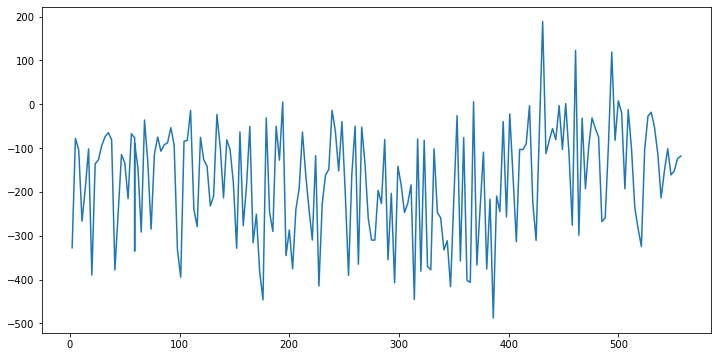

KeyboardInterrupt: 

In [5]:
print(f"Device is: {__device}")

# Start the timer
tstart = time.time()

# The experience of the agent is saved as a named tuple containing various variables
agentExp = namedtuple("exp", ["state", "action", "reward", "nextState", "done"])

# Parameters
nEpisodes = 2000 # Number of learning episodes
maxNumTimeSteps = 1000 # The number of time step in each episode
gamma = .995 # The discount factor
ebsilon = 1 if startEbsilon == None else startEbsilon # The starting  value of ebsilon
ebsilonEnd   = .1 # The finishing value of ebsilon
eDecay = eDecay # The rate at which ebsilon decays
miniBatchSize = 100 # The length of minibatch that is used for training
memorySize = 100_000 # The length of the entire memory
numUpdateTS = 4 # Frequency of time steps to update the NNs
numP_Average = 100 # The number of previous episodes for calculating the average episode reward

# Variables for saving the required data for later analysis
episodePointHist = [] # For saving each episode's point for later demonstration
episodeTimeHist = [] # For saving the time it took for episode to end
actionString = "" # A string containing consecutive actions taken in an episode (dellimited by comma, i.e. 1,2,4,2,1 etc.)
episodeHistDf = None
lstHistory = [] if lstHistory == None else lstHistory
initialCond = None # initial condition (state) of the episode
epPointAvg = -999999
latestChekpoint = 0

# Making the memory buffer object
mem = ReplayMemory(memorySize, __dtype, __device)

for episode in range(startEpisode, nEpisodes):
    initialSeed = random.randint(1,1_000_000_000) # The random seed that determines the episode's I.C.
    state, info = env.reset(seed = initialSeed)
    points = 0
    actionString = ""
    initialCond = state

    tempTime = time.time()
    _lastPrinttime = tempTime # For printing the training progress 
    for t in range(maxNumTimeSteps):

        qValueForActions = qNetwork_model(torch.tensor(state, device = __device, dtype = __dtype))

        # use ebsilon-Greedy algorithm to take the new step
        action = getAction(qValueForActions, ebsilon)

        # Take a step
        observation, reward, terminated, truncated, info = env.step(action)

        # Store the experience of the current step in an experience deque.
        mem.addNew(
            agentExp(
                state, # Current state
                action,
                reward, # Current state's reward
                observation, # Next state
                True if terminated or truncated else False
            )
        )

        # Check to see if we have to update the networks in the current step
        update = updateNetworks(t, mem, miniBatchSize, numUpdateTS)

        if update:
            initial_weights = {name: param.clone() for name, param in qNetwork_model.named_parameters()}
            # Update the NNs
            experience = mem.sample(miniBatchSize)

            # Update the Q-Network and the target Q-Network
            # Bear in mind that we do not update the target Q-network with direct gradient descent.
            # so there is no optimizer needed for it
            fitQNetworks(experience, gamma, [qNetwork_model, optimizer_main], [targetQNetwork_model, None])

        # Save the necessary data
        points += reward
        state = observation.copy()
        actionString += f"{action},"

        # Print the training status. Print only once each second to avoid jitters.
        if 1 < (time.time() - _lastPrinttime):
            clear_output(wait=True)
            _lastPrinttime = time.time()
            print(f"ElapsedTime: {int(time.time() - tstart): <5}s | Episode: {episode: <5} | Timestep: {t: <5} | The average of the {numP_Average: <5} episodes is: {int(epPointAvg): <5}")
            print(f"Latest chekpoint: {latestChekpoint} | Speed {t/(time.time()-tempTime):.1f} tps | ebsiolon: {ebsilon:.3f}")

            fig= plt.figure(figsize=(12,6))
            plt.plot(pd.DataFrame(lstHistory)["episode"], pd.DataFrame(lstHistory)["points"])
            plt.show()

        # Handle episode ending
        if terminated or truncated:
            # Save the episode history in dataframe
            if (episode+1) % 3 == 0:
                # only save every 10 episodes
                lstHistory.append({
                    "episode": episode,
                    "seed": initialSeed,
                    "points": points,
                    "timesteps": t,
                    "duration": time.time() - tempTime
                })
                
            break

    # Saving the current episode's points and time
    episodePointHist.append(points)
    episodeTimeHist.append(time.time()-tempTime)

    # Getting the average of {numP_Average} episodes
    epPointAvg = np.mean(episodePointHist[-numP_Average:])

    # Decay ebsilon
    ebsilon = decayEbsilon(ebsilon, eDecay, ebsilonEnd)

    # Save model weights and parameters periodically (For later use)
    if backUpNetworks:
        if (episode + 1) % 20 == 0:
            _chekcPoint = {
                "episode": episode,
                'model_state_dict': qNetwork_model.state_dict(),
                'optimizer_state_dict': optimizer_main.state_dict(),
                'hyperparameters': {"ebsilon": ebsilon, "eDecay":eDecay},
                "train_history": lstHistory
            }
            qNetworkSaveHistory.appendleft(_chekcPoint)
            torch.save(qNetworkSaveHistory, os.path.join(savePath, f"{projectName}_{modelDetails}_qNetwork_model.pth"))

            _chekcPoint = {
                "episode": episode,
                'model_state_dict': targetQNetwork_model.state_dict(),
                'optimizer_state_dict': optimizer_target.state_dict(),
                'hyperparameters': {"ebsilon": ebsilon, "eDecay":eDecay},
                "train_history": lstHistory
            }
            targetQNetworkSaveHistory.appendleft(_chekcPoint)
            torch.save(targetQNetworkSaveHistory, os.path.join(savePath, f"{projectName}_{modelDetails}_targetQNetwork_model.pth"))

            # Save the episode number
            latestChekpoint = episode

    # Stop the learning process if suitable average point is reacheds
    if 50 < epPointAvg:
        Tend = time.time()
        print(f"\nThe learning ended. Elapsed time for learning: {Tend-tstart}s")
        break

# Reset the index
episodeHistDf = pd.DataFrame(lstHistory)
episodeHistDf.reset_index(drop=True, inplace=True)

env.close()

In [ ]:
import matplotlib.pyplot as plt
fig= plt.figure(figsize=(12,6))
plt.plot(pd.DataFrame(lstHistory)["episode"], pd.DataFrame(lstHistory)["points"])

In [ ]:
point = testAgent("LunarLander-v2", qNetwork_model, "./data/lunarLander-0.gif")
print(f"Episode point is: {point}")